### The first week of active prep - experiments with classifiers using sklearn lib.
#### ( first iteration -> not the highest quality of EDA, tuning etc )

In [8]:
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
data = pd.read_csv("heart.csv")

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
from sklearn.model_selection import train_test_split as tts

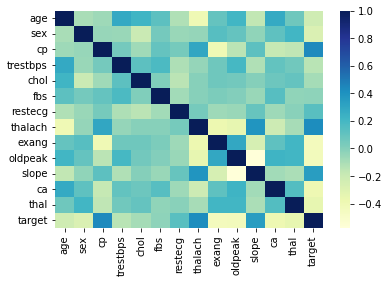

In [10]:
# firstly, I'd build the correlation matrix
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu")
# as can be seen, cp, slope and thalach seem to have the highest correlation among other. 
# thus, except for random forest, I would use them for LogReg, linear svm
# for random forest and kernel svm, I'd use all of the features.

In [11]:
X = data[['cp','thalach','slope','age','restecg','chol']]
y = data['target']

X_train, X_test, y_train, y_test = tts(X,y,test_size=0.2, random_state = 228)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(C = 55, solver ='liblinear')
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
print('The first iteration with logistic regression accuracy: ',
      accuracy_score(y_pred, y_test))

The first iteration with logistic regression accuracy:  0.8032786885245902


In [35]:
# now let's standardise the data:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.fit_transform(X_test)

In [49]:
lr = LogisticRegression(C=1, solver ='liblinear')
lr.fit(X_train_std,y_train)
y_pred = lr.predict(X_test_std)
print('The second iteration with logistic regression accuracy: ',
      accuracy_score(y_pred, y_test))
# However, this does not help here somehow *_* now we'll use the RandomForest classifier

The second iteration with logistic regression accuracy:  0.7868852459016393


In [54]:
# I'll use all data here
new_X = data.drop('target',axis=1)
new_X_train, new_X_test, new_y_train, new_y_test = tts(new_X,y,test_size=0.2, random_state = 228)



RandomForestClassifier(n_estimators=25, n_jobs=2, random_state=228)

In [108]:
from sklearn.ensemble import RandomForestClassifier

wood = RandomForestClassifier(n_estimators = 5,max_depth=4, random_state = 228, n_jobs = 2)
wood.fit(new_X_train, new_y_train)


RandomForestClassifier(max_depth=4, n_estimators=5, n_jobs=2, random_state=228)

In [109]:
y_pred1 = wood.predict(new_X_test)
print('The first iteration with Random Forest accuracy: ',
      accuracy_score(y_pred1, new_y_test))
#Here, we can see that the accuracy is ± 5% higher than in LR case

The first iteration with Random Forest accuracy:  0.8360655737704918


In [112]:
X_train_std1 = std.fit_transform(new_X_train)
X_test_std1 = std.fit_transform(new_X_test)

In [113]:
wood.fit(X_train_std1, new_y_train)
y_pred1 = wood.predict(X_test_std1)
print('The first iteration with Random Forest accuracy: ',
      accuracy_score(y_pred1, new_y_test))
#Scaling did not do much here tho...

The first iteration with Random Forest accuracy:  0.8524590163934426


### The results shown by Random forest are superior to LR, for now. I'll probably return to this dataset in the next weeks with better EDA and other methods used.
